<a href="https://colab.research.google.com/github/Jmmostafa/VaRBacktestingEngine/blob/main/01_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
# import statsmodels.api as sm

## Extracting Sample Data

In [141]:
symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
df = yf.download(symbols, start = '2020-01-01', auto_adjust=True)['Close'].dropna()
df.columns = ['EURUSD', 'GOLD', 'GSPC', '10Y']
df['10Y'] = df['10Y']/100
df.tail()

[*********************100%***********************]  4 of 4 completed


,EURUSD,GOLD,GSPC,10Y
Date,,,,
2025-12-08,1.164022,4187.200195,6846.509766,0.04172
2025-12-09,1.164144,4206.700195,6840.509766,0.04186
2025-12-10,1.162831,4196.399902,6886.680176,0.04164
2025-12-11,1.170124,4285.500000,6901.000000,0.04141
2025-12-12,1.173943,4300.100098,6827.410156,0.04194


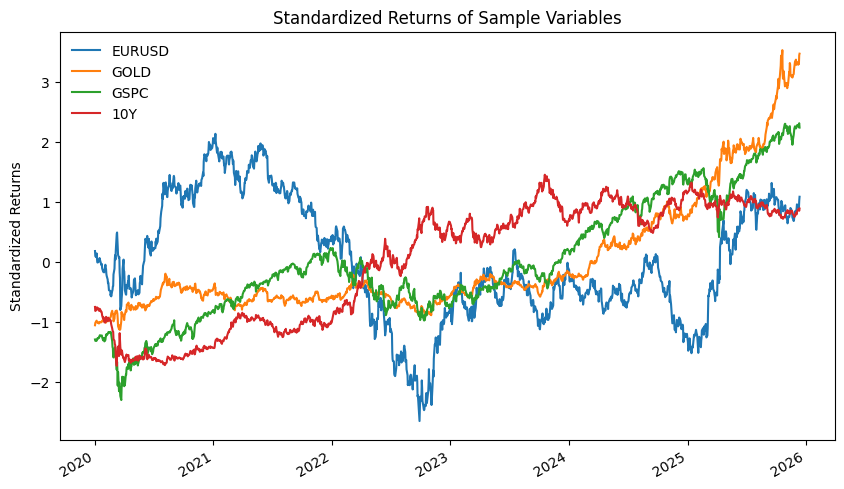

In [149]:
# standardizing the variables for comparison
df_standardized = (df - df.mean())/df.std()
df_standardized.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Standardized Returns')
plt.title('Standardized Returns of Sample Variables')
plt.legend(frameon = False)
plt.show()

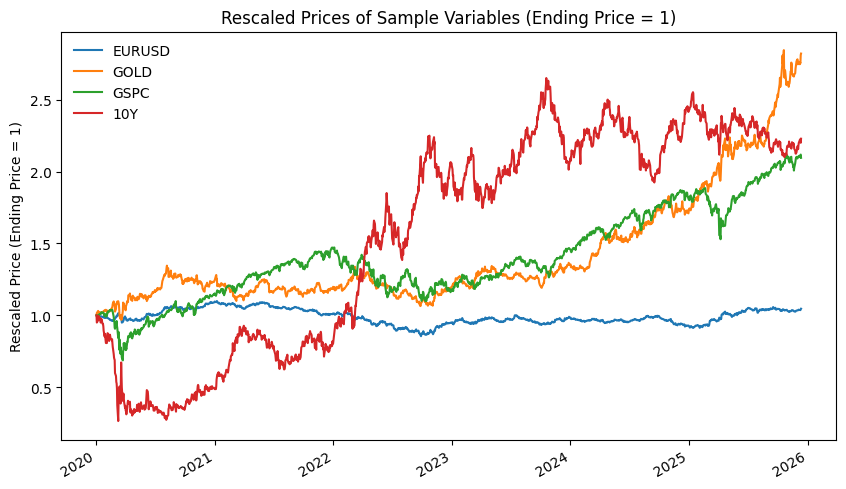

In [148]:
# rescaleding the data for visualization
df_rescaled = df / df.iloc[0]

df_rescaled.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Rescaled Price (Ending Price = 1)')
plt.title('Rescaled Prices of Sample Variables (Ending Price = 1)')
plt.legend(frameon = False)
plt.grid(False)
plt.show()

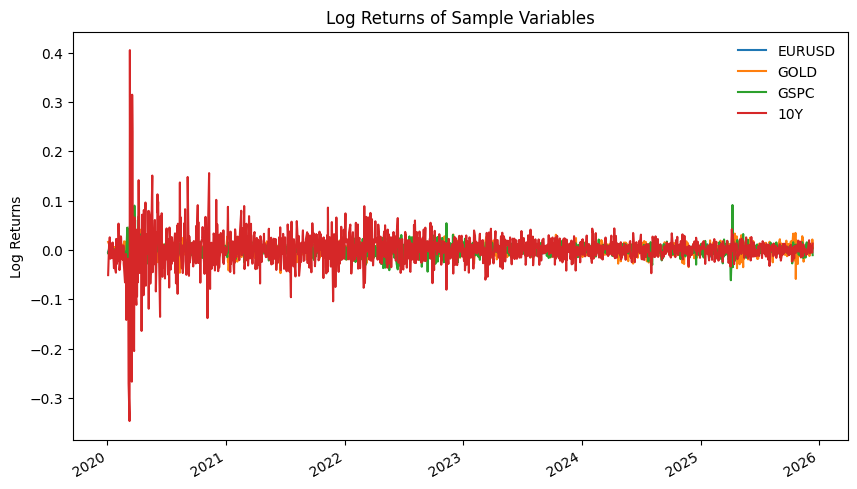

In [150]:
# calculating log returns
df_returns = np.log(df/(df.shift(1))).dropna()
df_returns.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Log Returns')
plt.title('Log Returns of Sample Variables')
plt.legend(frameon = False)
plt.show()

# Exploratory Analysis

In [123]:
# Descriptive statistics
all_stats_data = {}
for column in df_returns.columns:
  stats_data = {
      'Count': df_returns[column].count(),
      'Mean': df_returns[column].mean(),
      'Median': df_returns[column].median(),
      'Std Dev': df_returns[column].std(),
      'Skew': df_returns[column].skew(),
      'Kurt': df_returns[column].kurt(),
      'Min': df_returns[column].min(),
      'Max': df_returns[column].max(),
      '1% quantile': df_returns[column].quantile(0.01),
      '99% quantile': df_returns[column].quantile(0.99)
  }
  all_stats_data[column] = stats_data
df_stats = pd.DataFrame(all_stats_data)
df_stats

,BTCUSD,GOLD,SPY,10Y
Count,1495.000000,1495.000000,1495.000000,1495.000000
Mean,0.001712,0.000694,0.000552,0.000536
Median,0.001084,0.000969,0.000984,0.000482
Std Dev,0.039386,0.010721,0.013143,0.035671
Skew,-1.223009,-0.362533,-0.558280,0.255463
Kurt,16.269513,3.339691,13.358704,28.503739
Min,-0.464730,-0.059062,-0.115886,-0.347009
Max,0.191527,0.057775,0.099863,0.404797
1% quantile,-0.106147,-0.028288,-0.037719,-0.094679
99% quantile,0.104924,0.027796,0.030546,0.088917


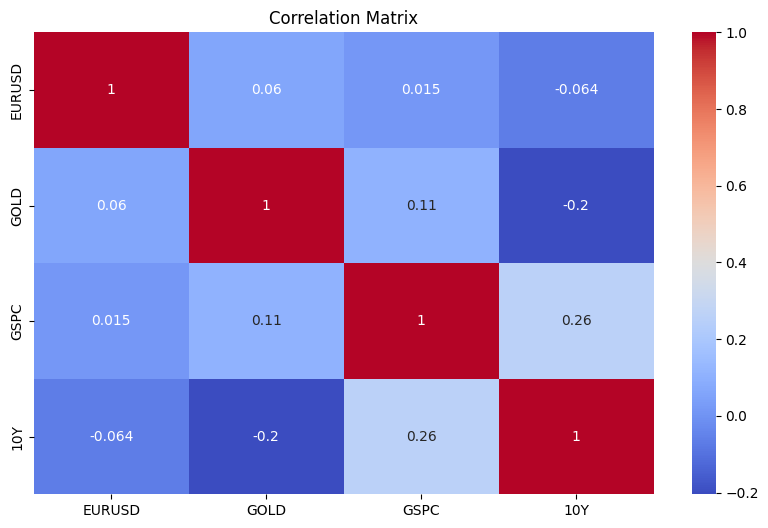

In [152]:
# Correlation Matrix
df_corr = df_returns.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

[*********************100%***********************]  4 of 4 completed


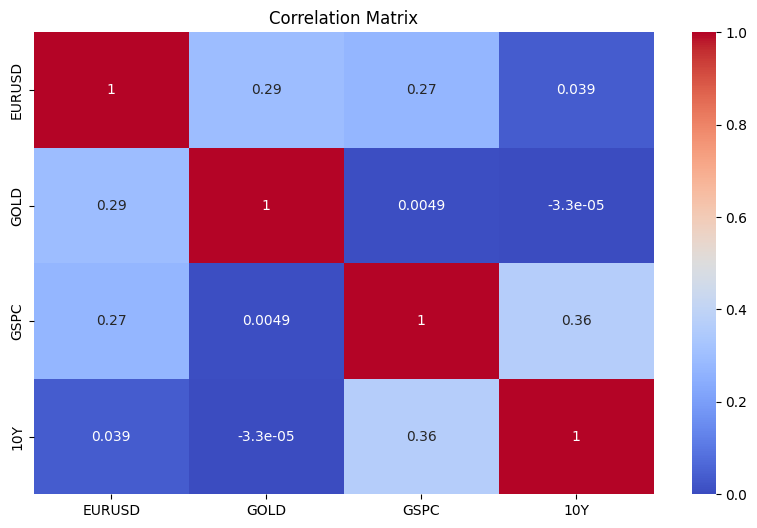

In [157]:
# correlations accross the stressed periods

symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
df_stressed = yf.download(symbols, start = '2007-01-01', end = '2009-12-31', auto_adjust=True)['Close'].dropna()
df_stressed.columns = ['EURUSD', 'GOLD', 'GSPC', '10Y']
df_stressed['10Y'] = df_stressed['10Y']/100

# Stressed Periods Correlations
df_stressed_returns = np.log(df_stressed/(df_stressed.shift(1))).dropna()
df_stressed_corr = df_stressed_returns.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(df_stressed_corr, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [130]:
yf.download('GC=F', start = '2007-01-01', end ='2009-31-12', auto_adjust=True)['Close']


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GC=F']: ValueError("time data '2009-31-12' does not match format '%Y-%m-%d'")


Ticker,GC=F
Date,


In [137]:
yf.download('^TNX', start='2007-01-01')

/tmp/ipython-input-66445739.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download('^TNX', start='2007-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^TNX,^TNX,^TNX,^TNX,^TNX
Date,,,,,
2007-01-03,4.664,4.692,4.636,4.658,0
2007-01-04,4.618,4.662,4.602,4.656,0
2007-01-05,4.646,4.700,4.583,4.587,0
2007-01-08,4.660,4.678,4.654,4.668,0
2007-01-09,4.656,4.670,4.644,4.660,0
...,...,...,...,...,...
2025-12-08,4.172,4.192,4.143,4.143,0
2025-12-09,4.186,4.190,4.143,4.162,0


In [127]:
# Time Series Analysis

In [146]:
df/df.iloc[0]

,EURUSD,GOLD,GSPC,10Y
Date,,,,
2020-01-02,1.000000,1.000000,1.000000,1.000000
2020-01-03,0.995599,1.016202,0.992940,0.950053
2020-01-06,0.994754,1.027353,0.996449,0.962274
2020-01-07,0.997965,1.031027,0.993655,0.970776
2020-01-08,0.994110,1.021581,0.998527,0.995749
...,...,...,...,...
2025-12-08,1.037377,2.746606,2.101542,2.216791
2025-12-09,1.037485,2.759397,2.099701,2.224230
2025-12-10,1.036315,2.752640,2.113873,2.212540


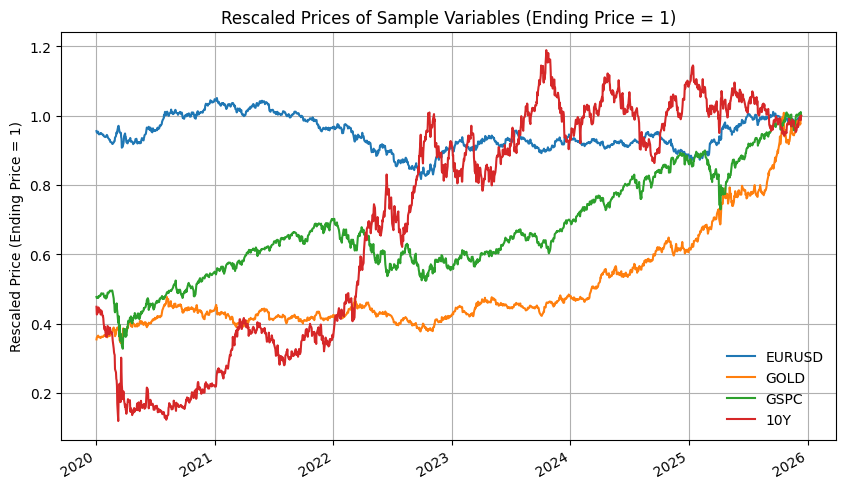

In [143]:
df_rescaled = df / df.iloc[-1]

df_rescaled.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Rescaled Price (Ending Price = 1)')
plt.title('Rescaled Prices of Sample Variables (Ending Price = 1)')
plt.legend(frameon = False)
plt.grid(True)
plt.show()